<a href="https://colab.research.google.com/github/hoonsyang/adversarial-robustness-toolbox/blob/master/notebooks/output_randomized_smoothing_mnist_YANG_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ART Randomized Smooting

In [4]:
import os
os.chdir('/content/drive/My Drive/Adversarial/adversarial-robustness-toolbox')
!pwd

/content/drive/My Drive/Adversarial/adversarial-robustness-toolbox


In [0]:
import keras.backend as k
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from art.config import ART_DATA_PATH
from art.defences import GaussianAugmentation
from art.classifiers import KerasClassifier
from art.utils import load_dataset, get_file, compute_accuracy
from art.wrappers import RandomizedSmoothing

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Load data

In [0]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

num_samples_test = 250
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

### Train classifiers

In [0]:
def cnn_mnist(input_shape, min_val, max_val):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val,max_val), model=model, use_logits=False)
    
    return classifier

In [10]:
num_epochs = 3

path = get_file('mnist_cnn_original.h5', extract=False, path=ART_DATA_PATH, url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')

classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [11]:
sigma1 = 0.25
sigma2 = 0.5

ga = GaussianAugmentation(sigma=sigma1, augmentation=False)
x_new1, _ = ga(x_train)
classifier_ga1 = cnn_mnist(x_train.shape[1:], min_, max_)
classifier_ga1.fit(x_new1, y_train, nb_epochs=num_epochs, batch_size=128)

ga = GaussianAugmentation(sigma=sigma2, augmentation=False)
x_new2, _ = ga(x_train)
classifier_ga2 = cnn_mnist(x_train.shape[1:], min_, max_)
classifier_ga2.fit(x_new2, y_train, nb_epochs=num_epochs, batch_size=128)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/3
468/468 [==============================] - 46s 99ms/step - loss: 0.3010 - acc: 0.9081
Epoch 2/3
468/468 [==============================] - 45s 97ms/step - loss: 0.0804 - acc: 0.9749
Epoch 3/3
468/468 [==============================] - 45s 97ms/step - loss: 0.0598 - acc: 0.9810
Epoch 1/3
468/468 [==============================] - 46s 97ms/step - loss: 0.3951 - acc: 0.8759
Epoch 2/3
468/468 [==============================] - 45s 96ms/step - loss: 0.1562 - acc: 0.9506
Epoch 3/3
468/468 [==============================] - 45s 97ms/step - loss: 0.1190 - acc: 0.9620


In [0]:
classifier_rs = RandomizedSmoothing(classifier, sample_size=100, scale=0.25, alpha=0.001)
classifier_rs1 = RandomizedSmoothing(classifier_ga1, sample_size=100, scale=sigma1, alpha=0.001)
classifier_rs2 = RandomizedSmoothing(classifier_ga2, sample_size=100, scale=sigma2, alpha=0.001)

### Prediction

In [16]:
x_preds = classifier.predict(x_test)
x_preds_rs1 = classifier_rs1.predict(x_test)
x_preds_rs2 = classifier_rs2.predict(x_test)
acc, cov = compute_accuracy(x_preds, y_test)
acc_rs1, cov_rs1 = compute_accuracy(x_preds_rs1, y_test)
acc_rs2, cov_rs2 = compute_accuracy(x_preds_rs2, y_test)

print("Original test data (first 250 images):")
print("Original Classifier")
print("Accuracy: {}".format(acc))
print("Coverage: {}".format(cov))

print("Smoothed Classifier, sigma=" + str(sigma1))
print("Accuracy: {}".format(acc_rs1))
print("Coverage: {}".format(cov_rs1))

print("Smoothed Classifier, sigma=" + str(sigma2))
print("Accuracy: {}".format(acc_rs2))
print("Coverage: {}".format(cov_rs2))

2 prediction(s) abstained.
5 prediction(s) abstained.
Original test data (first 250 images):
Original Classifier
Accuracy: 0.996
Coverage: 1.0
Smoothed Classifier, sigma=0.25
Accuracy: 1.0
Coverage: 0.992
Smoothed Classifier, sigma=0.5
Accuracy: 0.9918367346938776
Coverage: 0.98


### Certification accuracy and radius 

In [0]:
def getCertAcc(radius, pred, y_test):
    rad_list = np.linspace(0, 2.25, 201)
    cert_acc = []
    num_cert = len(np.where(radius > 0)[0])
    for r in rad_list:
        rad_idx = np.where(radius > r)[0]
        y_test_subset = y_test[rad_idx]
        cert_acc.append(np.sum(pred[rad_idx] == np.argmax(y_test_subset, axis=1))/num_cert)
    return cert_acc

In [0]:
pred0, radius0 = classifier_rs.certify(x_test, n=500)
pred1, radius1 = classifier_rs1.certify(x_test, n=500)
pred2, radius2 = classifier_rs2.certify(x_test, n=500)

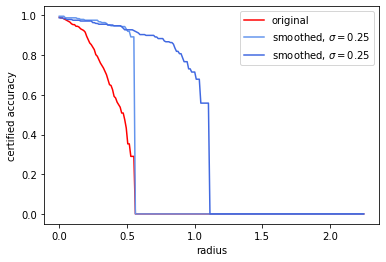

In [20]:
rad_list = np.linspace(0, 2.25, 201)

plt.plot(rad_list, getCertAcc(radius0, pred0, y_test), 'r-', label='original')
plt.plot(rad_list, getCertAcc(radius1, pred1, y_test), '-', color='cornflowerblue', label='smoothed, $\sigma=$' + str(sigma1))
plt.plot(rad_list, getCertAcc(radius2, pred2, y_test), '-', color='royalblue', label='smoothed, $\sigma=$' + str(sigma1))

plt.xlabel('radius')
plt.ylabel('certified accuracy')
plt.legend()
plt.show()